In [9]:
import math
import random
from typing import List, Tuple

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [11]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(device)

cuda


In [12]:
class Actor(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, output_shape),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        probs = self.net(x)
        dist = Categorical(probs)
        return dist

In [13]:
class Critic(nn.Module):
    def __init__(self, input_shape):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape[0], 128),
            nn.ReLU(),
            nn.Linear(128,1)
        )

    def forward(self, x):
        value = self.net(x)
        return value

In [78]:
class A2CAgent:
    def __init__(self, env, gamma, entropy_weight):
        self.env = env
        self.gamma = gamma
        self.entropy_weight = entropy_weight
        
        input_shape = env.observation_space.shape
        output_shape = env.action_space.n
        self.actor = Actor(input_shape, output_shape).to(device)
        self.critic = Critic(input_shape).to(device)
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr =1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        self.transition = list()
        self.is_test = False

    def select_aciton(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float).to(device)
        dist = self.actor(state_tensor)      
        selected_action = dist.sample()
        log_prob = dist.log_prob(selected_action)

        self.transition = [state, log_prob]
        
        return selected_action.cpu().numpy()

    def step(self, action):
        next_state, reward, done, _ = self.env.step(action)
        self.transition.extend([next_state, reward, done])
        
        return next_state, reward, done

    def update_model(self):
        state, log_prob, next_state, reward, done = self.transition
        mask = 1 - done
        state_tensor = torch.tensor(state, dtype=torch.float).to(device)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float).to(device)
        
        current_state_value = self.critic(state_tensor)
        next_state_value = reward + gamma * self.critic(next_state_tensor) * mask
        advantage = next_state_value - current_state_value

        log_prob_tensor = torch.tensor(log_prob, dtype=torch.float).to(device)

        actor_loss = -(log_prob_tensor * advantage).mean()
        critic_loss = nn.MSELoss()(next_state_value, current_state_value)
        loss = actor_loss + 0.5 * critic_loss

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

        return loss.item()

    def train(self, num_frames, plotting_interval=200):
        losses, scores = [], []
        state = self.env.reset()
        score = 0

        for self.total_step in range(1, num_frames+1):
           action = self.select_aciton(state)
           next_state, reward, done = self.step(action)

           loss = self.update_model()
           losses.append(loss)

           state = next_state
           score += reward

           if done:
              state = env.reset()
              scores.append(score)
              score = 0
              
           if self.total_step % plotting_interval == 0:
              self._plot(self.total_step, scores, losses)
        self.env.close()
    
    def test(self):
        """Test the agent."""
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float]        
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "loss", losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()        


In [79]:
env_id = "CartPole-v0"
env = gym.make(env_id)
env.reset()

array([-0.01307725,  0.01970717, -0.00613953,  0.00939516])

In [80]:
num_frames = 100000
gamma = 0.9
entropy_weight = 1e-2
agent = A2CAgent(env, gamma, entropy_weight)

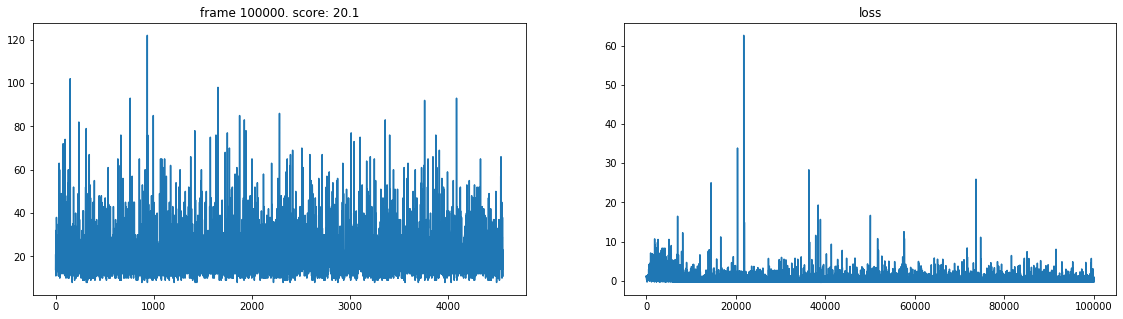

In [81]:
agent.train(num_frames)